In [1]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams.update({'font.size': 16})

import numpy as np

import lal
import lalsimulation as lalsim

# from scrinet.interfaces import lalutils, rotations 
from wispy import lalutils, rotations 


from tensorflow.keras.utils import get_custom_objects
import pugna.activations
import pugna.layers
import pugna.models
import pugna.callbacks
import wispy.mscalev2
import wispy.mscalev3
import wispy.mscalev4
import wispy.mscalev5
import wispy.model_utils
import wispy.callbacks
import wispy.utils
import wispy.logger
import wispy.resnet
import wispy
import subprocess
import datetime
import argparse
import sys
import os
import numpy as np
import tqdm
import tensorflow as tf
import tensorflow_addons as tfa

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

In [125]:
get_custom_objects().update({'s2relu': pugna.activations.s2relu})


In [2]:
# generate waveforms

1.1785016498623269 1.2246467991473532e-16 -0.0


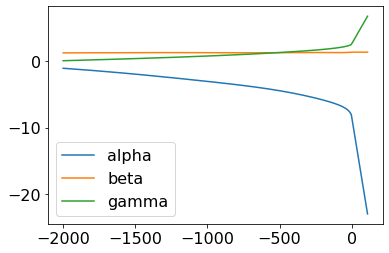

In [97]:
S1x=0.99
S2x=0.99

# S1x=0.
# S2x=0.

params = lalutils.gen_td_modes_wf_params(
    m1=100,
    m2=10,
    approximant=lalsim.SEOBNRv4P,
    S1x=S1x,
    S1y=0.,
    S2x=S2x,
    S2y=0.,
    f_min=12,
    f_ref=12,
    phiRef=1.2)

times, hlms = lalutils.gen_td_modes_wf(params, eob_all_ell_2_modes=True, modes=[[2,2],[2,1]], t_min=-2000, t_max=110)

thetaJN, alpha0, phi_aligned = rotations.compute_L_to_J_angles(
    mass1=params['m1'], mass2=params['m2'], f_ref=params['f_min'], inc=0, phiref=params['phiRef'],
    spin1x=params['S1x'], spin1y=params['S1y'], spin1z=params['S1z'],
    spin2x=params['S2x'], spin2y=params['S2y'], spin2z=params['S2z'])
print(thetaJN, alpha0, phi_aligned)

wr = rotations.WaveformRotations(
    times=times,
    hlms=hlms, 
    frame='inertial-L',
    alpha0=alpha0,
    thetaJN=thetaJN,
    phi0=phi_aligned) 

wr.from_inertial_frame_to_coprecessing_frame()

plt.figure()
plt.plot(wr.times, wr.alpha, label='alpha')
plt.plot(wr.times, wr.beta, label='beta')
plt.plot(wr.times, wr.gamma, label='gamma')
plt.legend()

wr.from_coprecessing_frame_to_inertial_frame()

In [98]:
# preprocess waveforms

In [99]:
# scale times
times_scaler = MinMaxScaler(feature_range=(-1,0))
# times_scaler = MinMaxScaler(feature_range=(-0.1,0))
X_train = times_scaler.fit_transform(times[:,np.newaxis])

In [100]:
X_train

array([[-1.00000000e+00],
       [-9.99786416e-01],
       [-9.99572832e-01],
       ...,
       [-4.27167877e-04],
       [-2.13583938e-04],
       [ 0.00000000e+00]])

In [101]:
scale_22 = np.abs(wr.hlms[(2,2)]).max()
print(scale_22)
# y_train = np.column_stack(
#     (wr.hlms[(2,2)].real/scale_22,wr.hlms[(2,2)].imag/scale_22)
# )

y_train = np.abs(wr.hlms[(2,2)])/scale_22
y_train = y_train[:, np.newaxis]

0.10620956808412164


In [102]:
y_train

array([[0.19542968],
       [0.19161033],
       [0.18772867],
       ...,
       [0.00097104],
       [0.00093576],
       [0.00089894]])

In [103]:
X_train.shape

(4683, 1)

In [104]:
y_train.shape

(4683, 1)

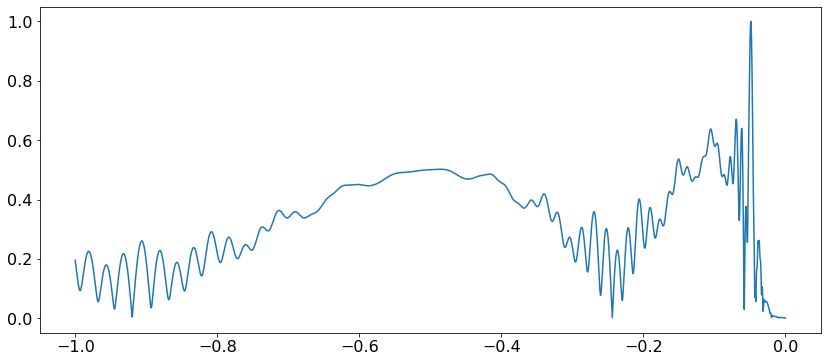

In [105]:
plt.figure(figsize=(14, 6))
plt.plot(X_train[:,0], y_train[:,0])

In [106]:
# fft

In [107]:
import pycbc.types.timeseries

In [108]:
import phenom

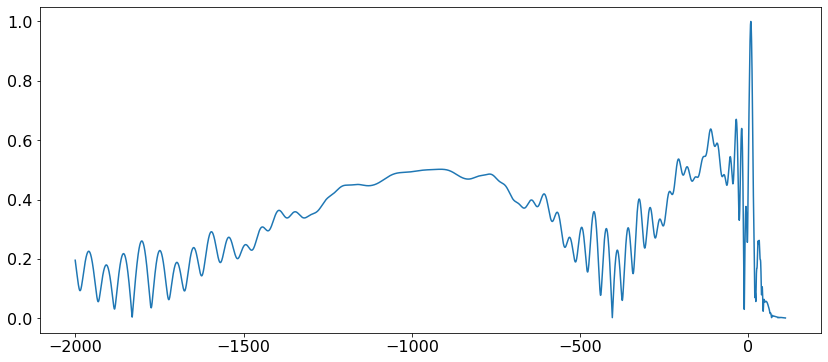

In [109]:
plt.figure(figsize=(14, 6))
plt.plot(times, y_train[:,0])

In [110]:
params['m1']

100

In [111]:
times_sec = phenom.MtoS(times, params['m1']+params['m2'])

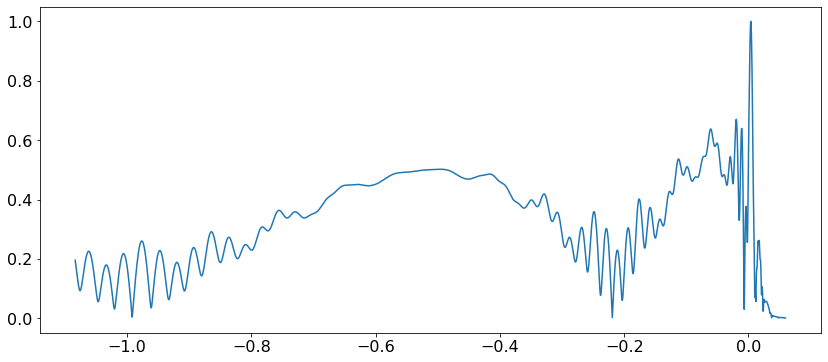

In [112]:
plt.figure(figsize=(14, 6))
plt.plot(times_sec, y_train[:,0])

In [113]:
ts = pycbc.types.timeseries.TimeSeries(y_train[:,0], delta_t=times_sec[1]-times_sec[0], epoch=times_sec[0])
ts_2 = pycbc.types.timeseries.TimeSeries(y_train[:,0], delta_t=(times_sec[1]-times_sec[0])*10, epoch=times_sec[0]*10)
ts_3 = pycbc.types.timeseries.TimeSeries(y_train[:,0], delta_t=(times_sec[1]-times_sec[0])*50, epoch=times_sec[0]*50)

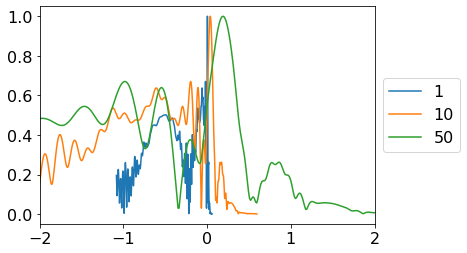

In [121]:
plt.plot(ts.sample_times, ts, label='1')
plt.plot(ts_2.sample_times, ts_2, label='10')
plt.plot(ts_3.sample_times, ts_3, label='50')
plt.xlim(-2, 2)
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))

In [122]:
fs = ts.to_frequencyseries()
fs_2 = ts_2.to_frequencyseries()
fs_3 = ts_3.to_frequencyseries()

In [123]:
mf = phenom.HztoMf(fs.sample_frequencies, params['m1']+params['m2'])
mf_2 = phenom.HztoMf(fs_2.sample_frequencies, params['m1']+params['m2'])
mf_3 = phenom.HztoMf(fs_3.sample_frequencies, params['m1']+params['m2'])

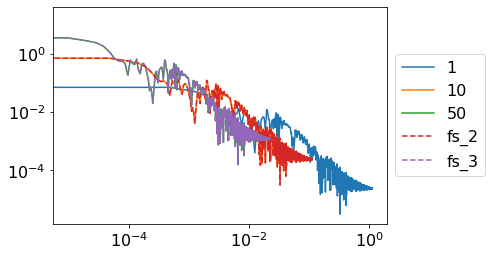

In [124]:
# plt.plot(fs.sample_frequencies, np.abs(fs))
plt.plot(mf, np.abs(fs), label='1')
plt.plot(mf/10, np.abs(fs)*10, label='10')
plt.plot(mf/50, np.abs(fs)*50, label='50')
plt.plot(mf_2, np.abs(fs_2), label='fs_2', ls='--')
plt.plot(mf_3, np.abs(fs_3), label='fs_3', ls='--')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='center left', bbox_to_anchor=(1,0.5))

In [12]:
# fit waveforms

In [13]:
def run_model(X_train, y_train, epochs=1001, threshold=1e-7, batch_size=32, validation_data=None):

    # try scales: pow of 2
#     scales = 2**np.arange(0,11,2)
#     scales = [1,10,50]
    scales = [1,10,50,100]
#     scales = [1,10,50,100, 0.01]
#     scales = [1,5,10,50,100,500]
    # scales = [1, 2, 5, 10, 20, 50, 100, 500]
    n_scales = len(scales)
    n_blocks = [1] * n_scales
    layers_per_block = 3
    units = [128] * n_scales
#     units = [256] * n_scales
    activation = "relu"
#     activation = "tanh"
    scale_activation="s2relu"


    model_params_dict = dict(
        input_shape=1,
        output_shape=y_train.shape[1],
        units=units,
        activation=activation,
        scale_activation=scale_activation,
        n_blocks=n_blocks,
        scales=scales,
        layers_per_block=layers_per_block,
        scale_dimension=0,
        dtype=None,
        skip_connection=False,
        skip_connection_dense=False,
        final_dense=False,
    )
    
    model = wispy.mscalev5.build_model(**model_params_dict)
    
    callbacks = [
        tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
        wispy.callbacks.ThresholdCallback(threshold),
        tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.9, monitor='loss')
    ]
    
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3))
    
    # history = model.fit(x=X_train, y=y_train['22_real'], epochs=201, verbose=0, batch_size=4000, callbacks=callbacks) 
    history = model.fit(x=X_train, y=y_train, epochs=epochs, verbose=0, batch_size=batch_size, callbacks=callbacks, validation_data=validation_data) 
    
    return history, model

In [14]:
X_train_fit, X_test_fit, y_train_fit, y_test_fit = train_test_split(X_train, y_train, test_size=0.33, random_state=42)

In [15]:
%%time
history, model = run_model(X_train_fit, y_train_fit, epochs=5000, batch_size=X_train.shape[0]//2, validation_data=(X_test_fit, y_test_fit))

Training:   0%|           0/5000 ETA: ?s,  ?epochs/s

CPU times: user 17min 18s, sys: 5min 16s, total: 22min 34s
Wall time: 5min 59s


In [16]:
history.history.keys()

dict_keys(['loss', 'val_loss', 'lr'])

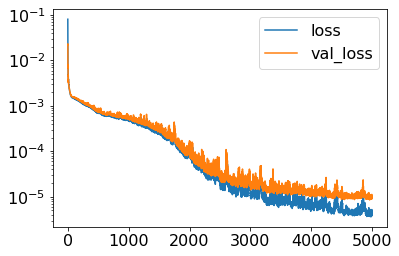

In [17]:
plt.figure()
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val_loss')
plt.legend()
plt.yscale("log")

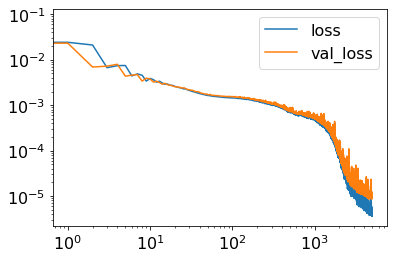

In [18]:
plt.figure()
plt.plot(history.history["loss"], label='loss')
plt.plot(history.history["val_loss"], label='val_loss')
plt.legend()
plt.yscale("log")
plt.xscale("log")

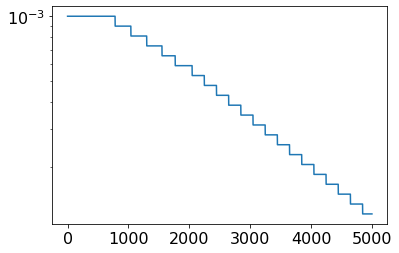

In [19]:
plt.figure()
plt.plot(history.history['lr'])
plt.yscale('log')

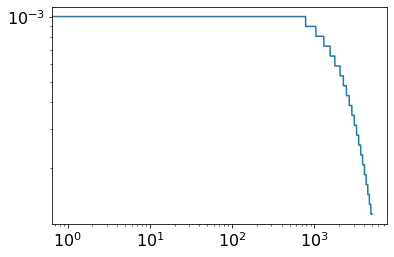

In [20]:
plt.figure()
plt.plot(history.history['lr'])
plt.yscale('log')
plt.xscale('log')

In [21]:
X_train.shape

(4683, 1)

In [22]:
y_train.shape

(4683, 1)

In [23]:
yhat = model.predict(X_train)

In [24]:
yhat.shape

(4683, 1)

In [25]:
X_train.shape

(4683, 1)

(-0.2, 0.1)

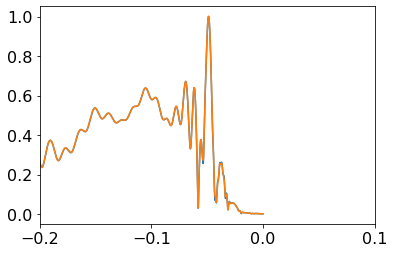

In [26]:
plt.figure()
plt.plot(X_train, y_train[:,0])
plt.plot(X_train, yhat[:,0])
plt.xlim(-0.2, 0.1)
# plt.xlim(-0.12, 0.01)
# plt.yscale('log')

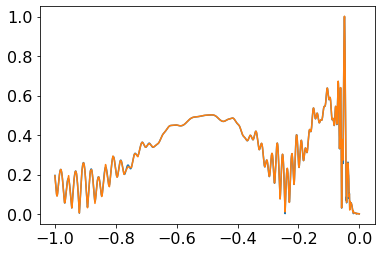

In [27]:
plt.figure()
plt.plot(X_train, y_train[:,0])
plt.plot(X_train, yhat[:,0])
# plt.xlim(-0.2, 0.1)
# plt.xlim(-0.12, 0.01)
# plt.yscale('log')

In [28]:
# plt.figure()
# plt.plot(X_train, y_train[:,1])
# plt.plot(X_train, yhat[:,1])
# # plt.xlim(-0.2, 0.1)

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
scale_layer (ScaleLayer)        (None, 1)            0           input_1[0][0]                    
__________________________________________________________________________________________________
scale_layer_1 (ScaleLayer)      (None, 1)            0           input_1[0][0]                    
__________________________________________________________________________________________________
scale_layer_2 (ScaleLayer)      (None, 1)            0           input_1[0][0]                    
______________________________________________________________________________________________

# run plain model

In [45]:
def run_plain_model(X_train, y_train, epochs=1001, threshold=1e-7, batch_size=32, validation_data=None,
                    num_hidden_layers=3,
                    units=128
                   ):
    
    input_shape = X_train.shape[1]
    output_shape = y_train.shape[1]
    
    input_layer = tf.keras.layers.Input(shape=(input_shape,))
    
    x = tf.keras.layers.Dense(units, activation="relu")(input_layer)
    
    for i in range(num_hidden_layers):
        x = tf.keras.layers.Dense(units, activation="relu")(x)
    
    x = tf.keras.layers.Dense(output_shape, activation="linear")(x)
    model = tf.keras.models.Model(inputs=input_layer, outputs=x)
    
    callbacks = [
        tfa.callbacks.TQDMProgressBar(show_epoch_progress=False),
        wispy.callbacks.ThresholdCallback(threshold),
        tf.keras.callbacks.ReduceLROnPlateau(min_lr=1e-6, patience=200, factor=0.9, monitor='loss')
    ]
    
    model.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(1e-3))
    
    # history = model.fit(x=X_train, y=y_train['22_real'], epochs=201, verbose=0, batch_size=4000, callbacks=callbacks) 
    history = model.fit(x=X_train, y=y_train, epochs=epochs, verbose=0, batch_size=batch_size, callbacks=callbacks, validation_data=validation_data) 
    
    return history, model

In [46]:
%%time
plain_history, plain_model = run_plain_model(X_train_fit, y_train_fit, epochs=5000, batch_size=X_train.shape[0]//2, validation_data=(X_test_fit, y_test_fit),
                                             num_hidden_layers=3,
                                             units=256)

Training:   0%|           0/5000 ETA: ?s,  ?epochs/s

CPU times: user 11min 17s, sys: 42.6 s, total: 12min
Wall time: 4min 36s


In [47]:
plain_history.history.keys()

dict_keys(['loss', 'val_loss', 'lr'])

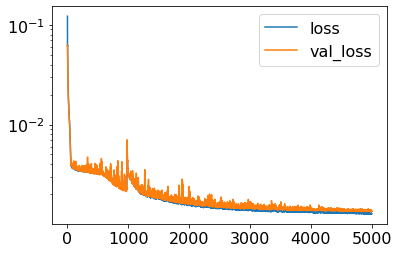

In [48]:
plt.figure()
plt.plot(plain_history.history["loss"], label='loss')
plt.plot(plain_history.history["val_loss"], label='val_loss')
plt.legend()
plt.yscale("log")

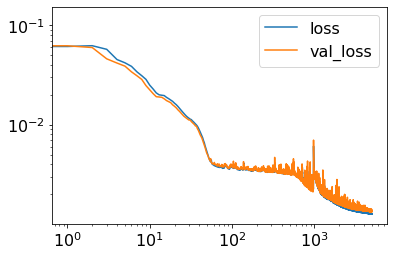

In [49]:
plt.figure()
plt.plot(plain_history.history["loss"], label='loss')
plt.plot(plain_history.history["val_loss"], label='val_loss')
plt.legend()
plt.yscale("log")
plt.xscale("log")

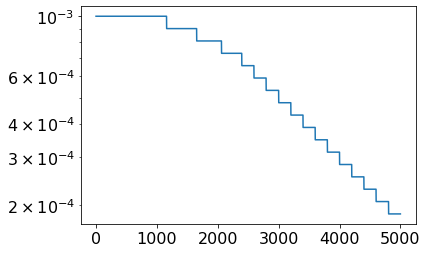

In [50]:
plt.figure()
plt.plot(plain_history.history['lr'])
plt.yscale('log')

In [51]:
plain_yhat = plain_model.predict(X_train)
# plain_yhat = plain_model.predict(X_test_fit)

In [52]:
plain_yhat.shape

(4683, 1)

In [53]:
X_train.shape

(4683, 1)

(-0.2, 0.1)

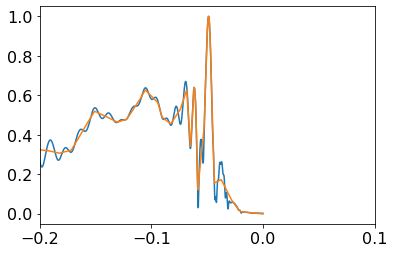

In [54]:
plt.figure()
plt.plot(X_train, y_train[:,0])
plt.plot(X_train, plain_yhat[:,0])
plt.xlim(-0.2, 0.1)

In [55]:
# plt.figure()
# plt.plot(X_train, y_train[:,1])
# plt.plot(X_train, plain_yhat[:,1])
# # plt.xlim(-0.2, 0.1)

In [56]:
plain_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
dense_21 (Dense)             (None, 256)               512       
_________________________________________________________________
dense_22 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_23 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_24 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 257       
Total params: 198,145
Trainable params: 198,145
Non-trainable params: 0
_____________________________________________________

# comparisons

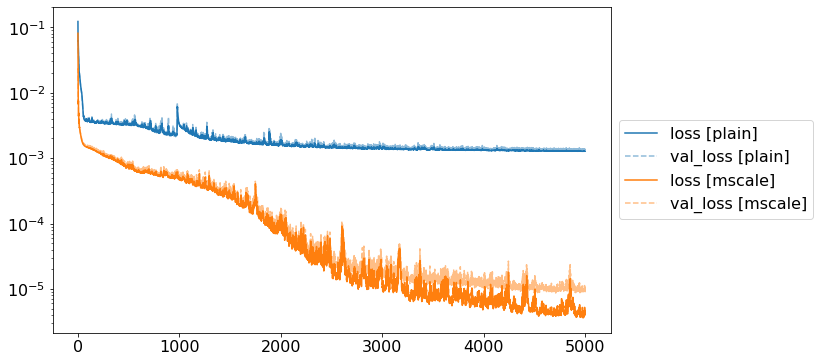

In [57]:
plt.figure(figsize=(10, 6))
plt.plot(plain_history.history["loss"], label='loss [plain]', c='C0')
plt.plot(plain_history.history["val_loss"], label='val_loss [plain]', ls='--', c='C0', alpha=0.5)

plt.plot(history.history["loss"], label='loss [mscale]', c='C1')
plt.plot(history.history["val_loss"], label='val_loss [mscale]', ls='--', c='C1', alpha=0.5)


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale("log")

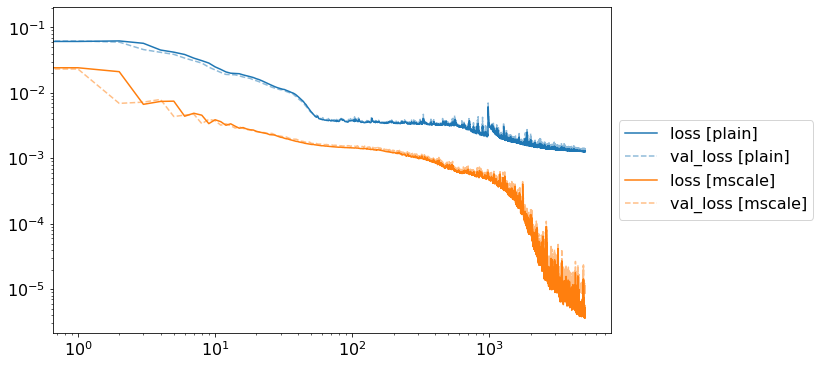

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(plain_history.history["loss"], label='loss [plain]', c='C0')
plt.plot(plain_history.history["val_loss"], label='val_loss [plain]', ls='--', c='C0', alpha=0.5)

plt.plot(history.history["loss"], label='loss [mscale]', c='C1')
plt.plot(history.history["val_loss"], label='val_loss [mscale]', ls='--', c='C1', alpha=0.5)


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.yscale("log")
plt.xscale("log")

(-1.05, 0.05)

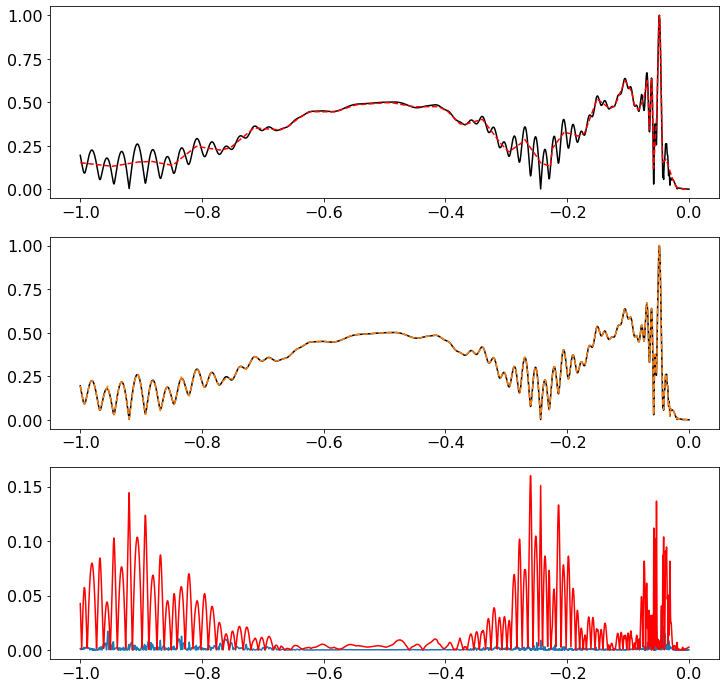

In [61]:
# xlim=(-0.09, -0.01)
xlim=(None, None)

plt.figure(figsize=(12, 12))
plt.subplot(3, 1, 1)
plt.plot(X_train, y_train[:,0], c='k')
plt.plot(X_train, plain_yhat[:,0], ls='--', c='r')
plt.xlim(*xlim)

plt.subplot(3, 1, 2)
plt.plot(X_train, y_train[:,0], c='k')
plt.plot(X_train, yhat[:,0], ls='--', c='C1')
plt.xlim(*xlim)


plt.subplot(3, 1, 3)
plt.plot(X_train, np.abs(y_train[:,0]-yhat[:,0]))
plt.plot(X_train, np.abs(y_train[:,0]-plain_yhat[:,0]), c='r')
plt.xlim(*xlim)
# plt.yscale('log')